In [1]:
#importing required libraries
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#importing sklearn libraries
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import cross_val_score

from numpy import interp
from itertools import cycle

In [2]:
#directory path for full dataset
imagedir ="/home/sanjeev/DL_POC/MlaImg_Data/Malimg_data/"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

Label: 0	Family:       Adialer.C	Number of images: 122
Label: 1	Family:       Agent.FYI	Number of images: 116
Label: 2	Family:       Allaple.A	Number of images: 2949
Label: 3	Family:       Allaple.L	Number of images: 1591
Label: 4	Family:   Alueron.gen!J	Number of images: 198
Label: 5	Family:       Autorun.K	Number of images: 106
Label: 6	Family:     C2LOP.gen!g	Number of images: 200
Label: 7	Family:         C2LOP.P	Number of images: 146
Label: 8	Family:  Dialplatform.B	Number of images: 177
Label: 9	Family:       Dontovo.A	Number of images: 162
Label:10	Family:        Fakerean	Number of images: 381
Label:11	Family:   Instantaccess	Number of images: 431
Label:12	Family:      Lolyda.AA1	Number of images: 213
Label:13	Family:      Lolyda.AA2	Number of images: 184
Label:14	Family:      Lolyda.AA3	Number of images: 123
Label:15	Family:       Lolyda.AT	Number of images: 159
Label:16	Family:     Malex.gen!J	Number of images: 136
Label:17	Family:   Obfuscator.AD	Number of images: 142
Label:18

In [4]:
vgg16 = np.load("/home/sanjeev/DL_Exp_Kajal/Finetune_stack_features/MalImg/vgg16_finetuned_feat_malimg_256.npy")
vgg19 = np.load("/home/sanjeev/DL_Exp_Kajal/Finetune_stack_features/MalImg/vgg19_feat_malimg_256.npy")
res = np.load("/home/sanjeev/DL_Exp_Kajal/Finetune_stack_features/MalImg/resnet50_feat_malimg_256.npy")
incv3 = np.load("/home/sanjeev/DL_Exp_Kajal/Finetune_stack_features/MalImg/inceptionV3_feat_malimg_256.npy")

In [5]:
X = []
for i in range(len(vgg16)):
    x = list(np.hstack((vgg16[i], vgg19[i], res[i], incv3[i])))
    X.append(x)

In [6]:
# X

In [7]:
X =  np.array(X)
X.shape

(9339, 1024)

In [8]:
label = np.array(y)
label.shape

(9339,)

In [9]:
cor_mat = pd.DataFrame(X).corr()
cor_mat.shape

(1024, 1024)

In [10]:
li = []
for i in range(1024):
    for j in range(1024):
        if i == j:
            pass
        else:
            if cor_mat[i][j] > 0.9:
                li.append([i, j])

In [11]:
lis_11 = [i[0] for i in li]
lis_22 = [i[1] for i in li]

In [12]:
x = sorted(list(set(lis_11)))
y = sorted(list(set(lis_22)))
x == y

True

#### Removal of most correlated features

In [13]:
s = {x for l in li for x in l}
len(s)

39

In [14]:
arr = X
arr = np.delete(arr, list(s), axis=1)
print(arr.shape)

(9339, 985)


In [43]:
# !pip install hyperopt

In [21]:
import hyperopt
from hyperopt import hp
from hyperopt.pyll import scope

In [70]:
space = {'n_units_l1':hp.randint('n_units_l1', 128), 'l2':hp.choice('l2', [{'has_l2': True, 
        'n_units_l2':hp.randint('n_units_l2', 128), 'l3':hp.choice('l3', [{'has_l3':True, 
        'n_units_l3':hp.randint('n_units_l3', 128), 'l4':hp.choice('l4', [{'has_l4':True,
        'n_units_l4':hp.randint('n_units_l4', 128),}, {'has_l4':False}]),}, {'has_l3':False}]),}, 
                                                                           {'has_l2':False}]),}

In [71]:
def objective (space):
    layers = [space['n_units_l1'] + 1]
    for i in range(2, 5):
        space = space['l{}'.format(i)]
        if not space['has_l{}'.format(i)]:
            break
        layers.append(space['n_units_l{}'.format(i)] + 1)

    clf = MLPClassifier(tuple(layers), max_iter=600)
    x_train, x_test, y_train, y_test = train_test_split(arr, label, test_size=0.20, random_state=31)

    clf.fit(x_train, y_train)
    return 1.0 - clf.score(x_test, y_test)

In [72]:
%%time
hyperopt.fmin(fn=objective, space=space, max_evals=100, algo=hyperopt.tpe.suggest)

 71%|███████   | 71/100 [13:50<16:13, 33.55s/trial, best loss: 0.013383297644539605]

/home/sanjeev/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  ConvergenceWarning,



100%|██████████| 100/100 [26:37<00:00, 15.97s/trial, best loss: 0.013383297644539605]
CPU times: user 8h 30min 8s, sys: 9h 51min 51s, total: 18h 21min 59s
Wall time: 26min 37s


{'l2': 0, 'l3': 1, 'n_units_l1': 60, 'n_units_l2': 15}

In [60]:
space_mlp = {}
space_mlp['hidden_layer_sizes'] = hp.uniform('hidden_layer_sizes', 50, 100)
space_mlp['learning_rate'] = hp.choice('learning_rate', ["constant", "invscaling", "adaptive"])
space_mlp['learning_rate_init'] = hp.uniform('learning_rate_init', 1e-4, 0.1)
space_mlp['max_iter'] = hp.uniform('max_iter', 500, 900)
space_mlp['early_stopping'] = hp.choice('early_stopping', [True, False])
space_mlp['activation'] = hp.choice('activation', ['relu', 'logistic', 'tanh'])
space_mlp['solver'] = hp.choice('solver', ['lbfgs', 'sgd', 'adam'])

In [61]:
space_mlp

{'hidden_layer_sizes': <hyperopt.pyll.base.Apply at 0x7f14a3ca6290>,
 'learning_rate': <hyperopt.pyll.base.Apply at 0x7f14a3ca6d10>,
 'learning_rate_init': <hyperopt.pyll.base.Apply at 0x7f14a3ca6350>,
 'max_iter': <hyperopt.pyll.base.Apply at 0x7f14a3ca6ad0>,
 'early_stopping': <hyperopt.pyll.base.Apply at 0x7f14a3ca6550>,
 'activation': <hyperopt.pyll.base.Apply at 0x7f14a3ca67d0>,
 'solver': <hyperopt.pyll.base.Apply at 0x7f14b0471050>}

In [62]:
type(arr), type(label)

(numpy.ndarray, numpy.ndarray)

In [63]:
def objective(params):
    clf = MLPClassifier(params)
    x_train, x_test, y_train, y_test = train_test_split(arr, label, test_size=0.20, random_state=31)

    clf.fit(x_train, y_train)
    return clf.score(x_test, y_test)

In [64]:
%%time
hyperopt.fmin(fn=objective, space=space_mlp, max_evals=100, algo=hyperopt.tpe.suggest)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

job exception: '<=' not supported between instances of 'numpy.ndarray' and 'int'



  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]


TypeError: '<=' not supported between instances of 'numpy.ndarray' and 'int'

In [29]:
X_train, X_test, y_train, y_test = train_test_split(arr, label, test_size=0.20, random_state=31)

In [25]:
print("X_train shape =", X_train.shape)
print("X_test shape =", X_test.shape)
print("y_train shape =", y_train.shape)
print("y_test shape =", y_test.shape)

X_train shape = (7471, 985)
X_test shape = (1868, 985)
y_train shape = (7471,)
y_test shape = (1868,)


In [18]:
%%time
clf = MLPClassifier(random_state=31, max_iter=500)
clf.fit(X_train, y_train)

CPU times: user 8min 59s, sys: 13min 17s, total: 22min 17s
Wall time: 40.9 s


MLPClassifier(max_iter=500, random_state=31)

In [31]:
print("Training Accuracy:", round((clf.score(X_train, y_train) * 100), 2))

Training Accuracy: 100.0


In [32]:
print("Testing Accuracy:", round((clf.score(X_test, y_test) * 100), 2))

Testing Accuracy: 97.91


In [21]:
%%time
y_pred = clf.predict(X_test)

CPU times: user 279 ms, sys: 192 ms, total: 471 ms
Wall time: 15.2 ms


In [22]:
%%time
ls = precision_recall_fscore_support(y_test, y_pred, average='micro')
print(int(round(ls[0]*100, 0)), int(round(ls[1]*100, 0)), int(round(ls[2]*100, 0)))

99 99 99
CPU times: user 72.1 ms, sys: 130 ms, total: 203 ms
Wall time: 6.45 ms


In [23]:
%%time
score = cross_val_score(clf, X, label, cv=5)
round(np.mean(score)*100, 2)

CPU times: user 22min, sys: 31min 29s, total: 53min 29s
Wall time: 1min 42s


98.34

Plotting the confusion matrix


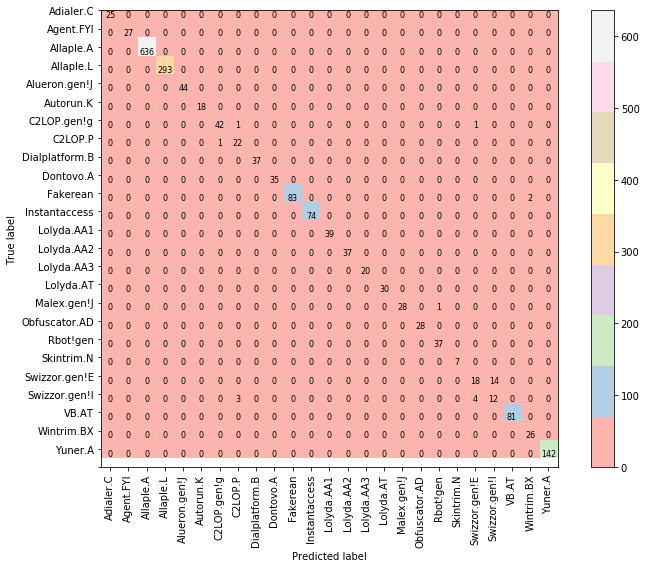

In [24]:
conf_matrix = confusion_matrix(y_test, y_pred)

print("Plotting the confusion matrix")
conf_mat = np.around(conf_matrix, decimals=2)  
figure = plt.gcf()
figure.set_size_inches(10, 8)
plt.imshow(conf_mat, interpolation='nearest', cmap='Pastel1')

for row in range(len(list_fams)):
    for col in range(len(list_fams)):
        plt.annotate(str(conf_mat[row][col]), xy=(col,row), ha='center', va='top', fontsize=8)
        
plt.xticks(range(len(list_fams)), list_fams, rotation=90, fontsize=10)
plt.yticks(range(len(list_fams)+1), list_fams, fontsize=10)

plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.tight_layout()
plt.colorbar()
# plt.savefig("/home/sanjeev/DL_Exp_Kajal/Finetune_stack_features/MalImg/Plots_malimg/Finetuned_plots/mlp_cm_corr.eps", bbox_inches='tight')
# plt.savefig("/home/sanjeev/DL_Exp_Kajal/Finetune_stack_features/MalImg/Plots_malimg/Finetuned_plots/mlp_cm_corr.png", bbox_inches='tight')

plt.show()

In [25]:
classification_metrices = metrics.classification_report(y_test, y_pred, target_names=list_fams)
print(classification_metrices)

                precision    recall  f1-score   support

     Adialer.C       1.00      1.00      1.00        25
     Agent.FYI       1.00      1.00      1.00        27
     Allaple.A       1.00      1.00      1.00       636
     Allaple.L       1.00      1.00      1.00       293
 Alueron.gen!J       1.00      1.00      1.00        44
     Autorun.K       1.00      1.00      1.00        18
   C2LOP.gen!g       0.98      0.95      0.97        44
       C2LOP.P       0.85      0.96      0.90        23
Dialplatform.B       1.00      1.00      1.00        37
     Dontovo.A       1.00      1.00      1.00        35
      Fakerean       1.00      0.98      0.99        85
 Instantaccess       1.00      1.00      1.00        74
    Lolyda.AA1       1.00      1.00      1.00        39
    Lolyda.AA2       1.00      1.00      1.00        37
    Lolyda.AA3       1.00      1.00      1.00        20
     Lolyda.AT       1.00      1.00      1.00        30
   Malex.gen!J       1.00      0.97      0.98  

In [26]:
# classification_metrices = metrics.classification_report(y_test, y_pred, output_dict=True, target_names= list_fams)
# df = pd.DataFrame(classification_metrices).transpose()
# df.to_csv('/home/sanjeev/DL_Exp_Kajal/Finetune_stack_features/MalImg/Plots_malimg/Finetuned_plots/mlp_cr_corr.csv')

In [27]:
print("micro_precision :", metrics.precision_score(y_test, y_pred, average='micro'))
print("micro_recall :", metrics.recall_score(y_test, y_pred, average='micro'))
print("micro_f1_score :", metrics.f1_score(y_test, y_pred, average='micro'))

micro_precision : 0.9855460385438972
micro_recall : 0.9855460385438972
micro_f1_score : 0.9855460385438972


In [28]:
print("macro_precision :", metrics.precision_score(y_test, y_pred, average='macro'))
print("macro_recall :", metrics.recall_score(y_test, y_pred, average='macro'))
print("macro_f1_score :", metrics.f1_score(y_test, y_pred, average='macro'))

macro_precision : 0.9587720331395495
macro_recall : 0.9618853588263565
macro_f1_score : 0.9588614488402925


In [29]:
print("weighted_precision :", metrics.precision_score(y_test, y_pred, average='weighted'))
print("weighted_recall :", metrics.recall_score(y_test, y_pred, average='weighted'))
print("weighted_f1_score :", metrics.f1_score(y_test, y_pred, average='weighted'))

weighted_precision : 0.9868416298768823
weighted_recall : 0.9855460385438972
weighted_f1_score : 0.9856732519999687


In [30]:
enc = OneHotEncoder()
enc.fit(y_train.reshape(-1, 1))  
y_test = enc.transform(y_test.reshape(-1, 1))
y_pred = enc.transform(y_pred.reshape(-1, 1))

In [31]:
y_test = y_test.toarray()
y_pred = y_pred.toarray()

In [32]:
n_classes = 25

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

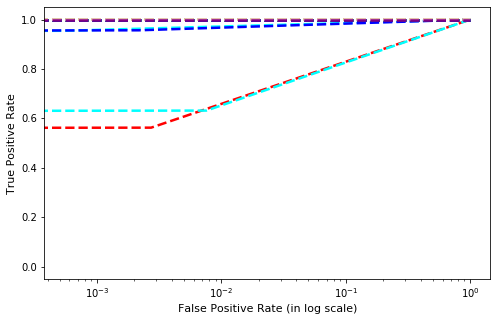

In [33]:
# Compute macro-average ROC curve and ROC area

n_classes = 25
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
lw = 2.5   # line width
plt.figure(figsize=(8,5))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'lightgreen', 'green', 'red', 'cyan', 'blue', 
                 'pink', 'purple', 'brown', 'coral', 'chocolate', 'indigo', 'navy'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, linestyle='dashed', lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.xscale("log")
plt.xlabel('False Positive Rate (in log scale)', fontsize=11)
plt.ylabel('True Positive Rate', fontsize=11)
# plt.savefig("/home/sanjeev/DL_Exp_Kajal/Finetune_stack_features/MalImg/Plots_malimg/Finetuned_plots/mlp_roc_corr.eps", bbox_inches='tight')
# plt.savefig("/home/sanjeev/DL_Exp_Kajal/Finetune_stack_features/MalImg/Plots_malimg/Finetuned_plots/mlp_roc_corr.png", bbox_inches='tight')

plt.show()